### Notes

#### Music sources

I found this after doing the internet archive work. It is likely a better choice, since
it has a variety of genres, and is a single zip. https://github.com/mdeff/fma

#### Indexing music

The Shazam algorithm is somewhat complex, and has nothing to do with deep learning.  Are we sure we want to use it?

# Building a Shazam clone

This notebook will walk through the steps needed to build a (simple) Shazam clone.  We'll first gather some music files from the Internet Archive.  Alternatively you can use your own library.  We then read and index them to allow for quick searching.

## Downloading from the Internet Archive

We want to download a number of files from the hiphop mixtape collection of the Internet Archive.  This collection is a good starting point as it contains a large variety of music from diverse artists and has enough tracks that we can  tell if we're doing a good job or not.

The webpage for this collection is here:  https://archive.org/details/hiphopmixtapes

Fortunately, the IA provides an API to access it and a Python library has been created to wrap the API already.  This simplifies our work significantly.

In [8]:
import internetarchive as ia
import os
import itertools
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)
# Run this the first time you use the library.  You'll need to register an IA account:
# https://archive.org/account/login.createaccount.php
# ia.configure()

In [2]:
MUSIC_DIR = os.path.expanduser('~/.cache/dl-cookbook/mp3')

def download_collection(max_items):
    count = 0
    archive_session = ia.session.ArchiveSession()
    search = ia.search.Search(archive_session, 'collection:hiphopmixtapes')
    for r in search.iter_as_items():
        kept_files = [
            f for f in r.files
            if (f['name'].endswith('.mp3') and
                float(f['size']) > 1*1000*1000 and
                float(f['size']) < 10*1000*1000)
        ]
        
        if not kept_files:
            continue
        
        r.download(files=[f['name'] for f in kept_files], destdir=MUSIC_DIR)
        count += len([f for f in r.files if f['name'].endswith('.mp3')])
        if count > max_items:
            return
    
os.system('mkdir -p "%s"' % MUSIC_DIR)

# This will take quite a while, and will use a few gigs of disk space.
download_collection(50)

01.IntelligentHoodlum: ............ - success
01.NAOCHOREMEUAMOR: ............ - success
01.Rebel: ... - success
01.RoleModel: ........ - success
01.YamborghiniHighFt.ASAPRockyASAPFergASAPNastASAPAntASAPTwelvyyJuicyJ: .......... - success
01BandoleroRemix: ..... - success


# Processing our data

Now that we have downloaded all of our music files, we want to build a search index for them.  This means we have to process them in a way that we can look up the right track given a short, noisy snippet of audio.  The authors of Shazam fortunately detail the process they use in this paper.  We will mostly follow the same mechanism:

https://github.com/papers-we-love/papers-we-love/blob/master/audio_comp_sci/shazam-audio-search-algorithm.pdf

## Reading MP3 files

There are a number of programs and libraries available for working with audio files, in this case MP3.

We're going to use librosa for this project.  It's easy to install with pip and provides a number of helpful utility functions we can make use of.

In [477]:
import librosa
import librosa.display

SAMPLE_RATE = 22050

def load_song(filename):
    return librosa.load(
        filename,
        sr=SAMPLE_RATE,
        mono=True,
        res_type='kaiser_fast',
        dtype='float32'
    )[0]


reality = load_song(MUSIC_DIR + '/01.IntelligentHoodlum/02. Back To Reality.mp3')
footprints = load_song(MUSIC_DIR + '/01PushItAlong/04 Footprints.mp3')

In [426]:
samples = reality
import scipy.signal

# Throw away most of the high frequency noise
def compute_spectrogram(samples):
    f,t, spectrogram = scipy.signal.spectrogram(samples, nperseg=SAMPLE_RATE)
    return spectrogram[:1024, :]

def plot_spectrogram(spectrogram):
    D = librosa.amplitude_to_db(spectrogram)
    plt.imshow(D)

## Generating an index

Now that we know how to do some basic processing of our audio files, we need to figure out a way to index them.  What we want to do is generate a set of _keys_ from each of our spectrogram that are reasonably unique, and also _robust_ to noise or compression.  This isn't an obvious task. 

One thing that looks promising is the peaks from our spectrogram: we can extract local peaks from each spectrogram, and derive our keys from that.  This is the approach taken by Shazam.

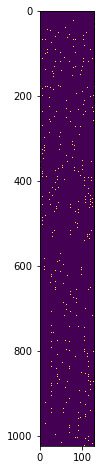

In [468]:
# Detecting peaks.  This is a lot of data, and too slow to do in plain Python.
# 
# We can leverage something like scipy, or write it ourselves in Cython.
# Let's use scipy here.
from scipy import ndimage
from scipy.ndimage import filters

def find_peaks(spectrogram, density=0.01, kp_density=0.005):
    neighborhood = 8
    found_peaks = 1000000
    threshold = 1
    desired_peaks = density * np.product(spectrogram.shape)
    
    
    img = librosa.amplitude_to_db(spectrogram)

    for i in range(10):
        img_max = filters.maximum_filter(img, size=neighborhood)
        img_min = filters.minimum_filter(img, size=neighborhood)
        maxima = (img == img_max)
        diff = (img_max - img_min) > threshold
        maxima[diff == 0] = 0
        num_peaks = np.count_nonzero(maxima)
        if num_peaks < desired_peaks * 2:
            break
        
        img *= 0.5
    
    peak_values = img[maxima]
    peaks = np.nonzero(maxima)
    top_peaks = np.argsort(peak_values)[:int(kp_density * np.product(spectrogram.shape))]
    return { 'peaks': peaks, 'kps': top_peaks }

def plot_peaks(peaks):
    x, y = peaks['peaks']
    img = np.zeros((1 + max(x), 1 + max(y)))
    img[x, y] = 1
    plt.imshow(img)    

peaks = find_peaks(compute_spectrogram(samples)[:,:128])
plot_peaks(peaks)

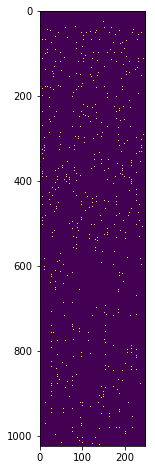

In [469]:
plot_peaks(find_peaks(compute_spectrogram(samples)))

In [470]:
noise = np.random.normal(0,np.mean(np.abs(samples)), len(samples))
noisy_samples = samples + noise
noisy_peaks = find_peaks(compute_spectrogram(noisy_samples)[:, :128])

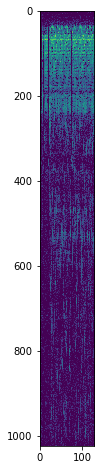

In [471]:
plot_spectrogram(compute_spectrogram(noisy_samples)[:, :128])

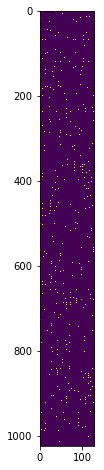

In [472]:
plot_peaks(noisy_peaks)

In [473]:
# Our peaks remain mostly the same, even in the presence of noise.  This is encouraging.
def hash_keys(peaks, F=10):
    x, y = peaks['peaks']
    kps = peaks['kps']
    random_state = np.random.RandomState()
    keys = []
    for i in kps: #range(0, len(x) - F):
        if i > len(x) - F:
            continue
        
        kp_x, kp_y = x[i], y[i]
        increment = abs(hash(i))
        random_state.seed(kp_y)
        tgt_idx = random_state.randint(i+1, len(x), F)
        for j in tgt_idx:
            tgt_x, tgt_y = x[j], y[j]
            keys.append((kp_y, tgt_x - kp_x, tgt_y - kp_y))
    
    return keys

all_peaks = find_peaks(compute_spectrogram(samples))
all_keys = hash_keys(all_peaks)
clean_keys = hash_keys(peaks)
noisy_keys = hash_keys(noisy_peaks)
footprints_keys = hash_keys(find_peaks(compute_spectrogram(footprints)))

In [474]:
len(all_keys)

12860

In [475]:
{
    'clean-noisy-aligned': len(set(clean_keys).intersection(set(noisy_keys))),
    'clean-all-unaligned': len(set(clean_keys).intersection(set(all_keys))),
    'noisy-all-unaligned': len(set(noisy_keys).intersection(set(all_keys))),
    'different-song-all-unaligned': len(set())
}

{'clean-all-unaligned': 189, 'clean-noisy-aligned': 50, 'different-song-all-unaligned': 0, 'noisy-all-unaligned': 24}

## Indexing our data

Now that we have a proof of concept working, let's compute keys for our entire dataset. 

In [479]:
import multiprocessing
import numpy as np
import struct
import sys

def index_file(filename):
    print(filename)
    samples = load_song(filename)
    keys = hash_keys(find_peaks(compute_spectrogram(samples)))
    return {'file': filename, 'index': keys }

def compute_all():
    pool = multiprocessing.Pool()    
    mp3s = os.popen("find '%s' -name '*.mp3'" % MUSIC_DIR).read().split('\n')
    mp3s = [f for f in mp3s if f.endswith('.mp3')]
    mp3s = mp3s[:10]
    
    result = pool.map(index_file, mp3s)
    pool.close()
    pool.join()
    
    return result

hashes = compute_all()

/Users/power/.cache/dl-cookbook/mp3/01.IntelligentHoodlum/02. Back To Reality.mp3
/Users/power/.cache/dl-cookbook/mp3/01.IntelligentHoodlum/03. Trag Invasion.mp3
/Users/power/.cache/dl-cookbook/mp3/01.IntelligentHoodlum/04. No Justice, No Peace.mp3
/Users/power/.cache/dl-cookbook/mp3/01.IntelligentHoodlum/01. Intelligent Hoodlum.mp3
/Users/power/.cache/dl-cookbook/mp3/01.IntelligentHoodlum/05. Party Animal.mp3
/Users/power/.cache/dl-cookbook/mp3/01.IntelligentHoodlum/06. Black And Proud.mp3
/Users/power/.cache/dl-cookbook/mp3/01.IntelligentHoodlum/07. Game Type.mp3
/Users/power/.cache/dl-cookbook/mp3/01.IntelligentHoodlum/08. Microphone Check.mp3
/Users/power/.cache/dl-cookbook/mp3/01.IntelligentHoodlum/09. Keep Striving.mp3
/Users/power/.cache/dl-cookbook/mp3/01.IntelligentHoodlum/10. Party Pack.mp3


[{'file': '/Users/power/.cache/dl-cookbook/mp3/01.IntelligentHoodlum/01. Intelligent Hoodlum.mp3',
  'index': [(44, 798, 160),
   (44, 656, 44),
   (44, 312, 69),
   (44, 175, 285),
   (44, 898, -25),
   (44, 519, 183),
   (44, 945, 211),
   (44, 684, 26),
   (44, 655, 256),
   (44, 706, 11),
   (172, 993, -8),
   (172, 900, 142),
   (172, 183, 140),
   (172, 157, -28),
   (172, 140, -41),
   (172, 396, 62),
   (172, 881, 63),
   (172, 182, -149),
   (172, 764, -58),
   (172, 945, 52),
   (30, 875, 22),
   (30, 157, 39),
   (30, 244, 98),
   (30, 298, 285),
   (30, 578, 169),
   (30, 97, 257),
   (30, 879, 3),
   (30, 63, 124),
   (30, 272, 298),
   (30, 780, 289),
   (130, 138, -85),
   (130, 324, -16),
   (130, 777, 180),
   (130, 471, -57),
   (130, 532, -50),
   (130, 964, 150),
   (130, 388, 128),
   (130, 99, 121),
   (130, 215, 82),
   (130, 687, 66),
   (198, 281, 92),
   (198, 43, 32),
   (198, 996, -58),
   (198, 201, -119),
   (198, 769, 18),
   (198, 558, 89),
   (198, 600,

# TODO Douwe

### How to insert these into Postgres 

We need to build an inverted index from hash -> idx, and count the number of intersections.  I'm not sure how to do that in Postgres... you could treat each hash as a word and then use the full text search?